# Assignment 2

You are expected to complete this notebook with lines of code, plots and texts. You will need to create new cells with original code or text for your analyses and explanations. Explain what you do and analyze your results. This assignment has a total of 100 points.

Using Canvas, you will deliver the notebook file (.ipynb) with cells executed and outputs visible.
- You should use PyTorch 1.0 or later as your deep learning framework. If you need to import a different package than the ones already imported, ask the TA if you can do it.
- No other data than the dataset variables provided should be used, and training, validation and testing splits should be the same as the ones provided.
- The cell outputs present in your delivered notebook should be reproducible by us by running your notebook cells in order.
- All code must be your own work. Code cannot be copied from another source or student. You may copy code from cells that were pre-defined in this notebook if you think it is useful for use in another part of the notebook.
- All images must be generated from data generated in your code. Do NOT import/display images generated outside your code.
- Your analysis must be your own, but if you quote text or equations from another source make sure to cite the reference.
- It is assumed that PyTorch is already installed according to the CADE or the COLAB tutorial.

Other notes:
- Cells should be run in order, using Shift+Enter.
- Read all the provided code cells and its comments, as it contains variables and information that you may need to use to complete the notebook.
- To create a text cell, create it with the "+" button and change its type from "Code" to "Markdown" using the top menu. To modify a text cell, double click on it.
- If you are interested, you can check detail on formatting markdown text here: https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed
- The accuracies provided as required for each question are there to make sure you work enough on each model to get a good result. Part of the grade is based on this.

Tips for training deep learning models:
- Since the datasets being used here are small, you are probably going to have to use early stopping as a way of preventing overfitting. This means you will have to save models in the middle of training. One of the ways to save models on memory is to do a deep copy of it (using ```copy.deepcopy``` ). 
- It is also recommended to frequently (at least once every epoch) print the loss of the model and the score it is getting at its intended task, to follow if the model is learning something and if it is still improving. Usually you will need somewhere between 1 and 15 epochs for your model to get the required accuracy in this assignment.
- To search for the best hyperparameters for your model, it is usually better to start searching in a logarithmic scale. Usually powers of 2 or 10 are used. 
- In https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2, different optimal learning rates for different optimizers were found for a different task. This could help in your search of optimal learning rate. For this assignment, you will probably get the best results by using Adam and searching for the best learning rate in the range of good learning rates provided in the cited page, which for Adam is from 0.00005 to 0.01.
- Batch size seems to have a smaller impact than learning rate in the results. It should be enough if you test batch sizes between 8 and 32.
- We assume a GPU of at least 4GB of memory is available. If you want to try running the assignment with a GPU that has less than that, you can try changing the argument passed when calling the ```define_gpu_to_use``` function.  If you are getting out-of-memory errors for the GPU, you may want to check what is occupying the GPU memory by using the command ```!nvidia-smi```, which gives a report of the use of the GPU. 
- For some of the questions, it might be useful for you to understand what the resnet18 PyTorch model is doing. You can have access to its source code here: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py . The most important part to understand should be the ```forward``` function from the ```ResNet``` class. It might also be useful to print PyTorch models using ```print(model)```. This should give you a list of all the layers present in the model.
- Between CADE and COLAB (i.e. Google Colaboratory), CADE is probably the best option for running this assignment, since it seems to be about 50% faster than COLAB and files are not erased when resetting sessions. CADE has a small disk quota for the home directory, so it might be necessary, depending on how much your home directory is already occupied, to store the virtual environment inside a folder in ```/scratch/tmp/```. For CADE, datasets are already downloaded and stored in a scratch folder accessible to everyone.
- If you are using Google Colaboratory, it might be interesting to store the datasets on your Google Drive to prevent having to download it every time you restart your sessions. For that, you will probably need to add the line ```drive.mount('/content/gdrive')``` and change the ```pre_folder``` variable to ```'gdrive/My Drive'```. This was not tested, so some adjustments may be needed.
- There are a few PyTorch details not to forget:
    - Remember to toggle train/eval mode for your model
    - Remember to reset the gradients with ```zero_grad()``` before each call to ```backward()```
    - Remember to check if the loss you are using receives logits or probabilities, and adapt your model output accordingly.
    - Remember to reinstantiate your model every time you are starting a new training, so that weights are reset.
    - Remember to pass to the optimizer the set of parameters for the model you want to train.
- Starting training from a pretrained model instead of starting it from scratch usually helps to get a better final result. For the exercises that use the resnet18 model from PyTorch, you can start training with the model pretrained on ImageNet that is provided by PyTorch.

#### Installing and loading libraries

In [1]:
!pip3 install -q kaggle
!pip3 install pydicom
!pip3 install scikit-learn

In [2]:
import getpass
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sys
from sklearn.metrics import roc_curve, auc
import copy
import torchvision.models as models
import tarfile
%matplotlib inline

#### Defining folders where data should be saved/loaded

In [3]:
#checking what kind of system you are using
try:
  import google.colab
  from google.colab import drive
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False
try:
    hostname = !hostname
    if 'lab' in hostname[0] and '.eng.utah.edu' in hostname[0]:
        IN_CADE = True
    else:
        IN_CADE = False
except:
    IN_CADE = False

assert(not IN_CADE or not IN_COLAB)

#defining the folders where datasets will be, depending on the system
machine_being_used = 'cade' if IN_CADE else ('colab' if IN_COLAB else 'other')
pre_folder = '/scratch/tmp/' if machine_being_used == 'cade' else './'
pneumonia_dataset_folder = pre_folder + 'deep_learning_datasets_ECE_6960_013/kaggle_pneumonia'
xray14_dataset_folder = pre_folder + 'deep_learning_datasets_ECE_6960_013/chestxray14'

#### Defining the GPU to use and reserving its memory for this notebook

In [4]:
# with this function you set the value of the environment variable CUDA_VISIBLE_DEVICES
# to set which GPU to use
# it also reserves this amount of memory for your exclusive use. This might be important for 
# not having other people using the resources you need in shared systems
# the homework was tested in a GPU with 4GB of memory, and running this function will require at least
# as much
# if you want to test in a GPU with less memory, you can call this function
# with the argument minimum_memory_mb specifying how much memory from the GPU you want to reserve
def define_gpu_to_use(minimum_memory_mb = 3800):
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        if free_memory>minimum_memory_mb-500:
            gpu_to_use = i
            break
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' +str(minimum_memory_mb) + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-500)).cuda()
        x = torch.rand((1,1)).cuda()
        del x

In [5]:
#setting the gpu that will be used, testing if it has enough available memory, and reserving the needed memory
define_gpu_to_use()

Chosen GPU: 0


#### Defining functions that are used internally in both exercises

In [6]:
# defining a pre-transformation class that is used to preprocess the images
# this class receives a Pillow Image, and crops it so that it has a 1:1 aspect
# ratio (i.e. a square). It chooses the biggest square possible that fits in the image
# and centers it.
# this is important for medical datasets, since a lot of them have images
# with different aspect ratios and this is one way of dealing with it and 
# standardizing the inputs
class CropBiggestCenteredInscribedSquare(object):
    def __init__(self):
        pass

    def __call__(self, tensor):
        longer_side = min(tensor.size)
        horizontal_padding = (longer_side - tensor.size[0]) / 2
        vertical_padding = (longer_side - tensor.size[1]) / 2
        return tensor.crop(
            (
                -horizontal_padding,
                -vertical_padding,
                tensor.size[0] + horizontal_padding,
                tensor.size[1] + vertical_padding
            )
        )

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [7]:
#split can be 'train', 'val', and 'test'
#this is the function that splits a dataset into training, validation and testing set
#We are using a split of 60%-20%-20%, for train-val-test, respectively
#this function is used internally to the defined dataset classes
# In medical datasets possibly containing more than one example for the same subject/patient,
# this function should be applied to the list of patients/subjects, and not to the list of examples
# since in a real-world application you will not find the same subject/patient as your training data had,
# and therefore you should measure how well your model is doing in the same settings
def get_split(array_to_split, split):
    np.random.seed(0)
    np.random.shuffle(array_to_split)
    np.random.seed()
    if split == 'train':
        array_to_split = array_to_split[:int(len(array_to_split)*0.6)]
    elif split == 'val':
        array_to_split = array_to_split[int(len(array_to_split)*0.6):int(len(array_to_split)*0.8)]
    elif split == 'test':
        array_to_split = array_to_split[int(len(array_to_split)*0.8):]
    return array_to_split


#### Defining functions that might be useful for you in both exercises

In [8]:
# use this function to 
# count how many parameters (learnable parameters, more specifically)
# there are in a pytorch model
def count_number_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Exercise 1: ChestXray14 Dataset
**(56 points total)**
>### Brief explanation of the dataset
> In this exercise we will use the ChestXray14 dataset. This dataset contains more than 100,000 frontal chest x-rays and labels for 14 different conditions. These labels were extracted from radiologists' reports associated with each image using natural language processing techniques. It was released at the end of 2017 and until the beginning of 2019, when CheXpert (https://stanfordmlgroup.github.io/competitions/chexpert/) and MIMIC-CXR (https://physionet.nlm.nih.gov/physiobank/database/mimiccxr/) were released, it was the best source for a large amount of training data for models using chest x-rays. These other two mentioned datasets contain about 300,000 images each, and contain x-ray studies with both the lateral and the frontal view. Using both views has been shown to improve results in deep learning models (https://arxiv.org/abs/1804.07839). More information about the ChestXray14 dataset can be found here: https://stanfordmlgroup.github.io/projects/chexnet/. The dataset was also criticized regarding the choice of label classes, among other things. More information about this can be found in these two blog posts by Luke Oakden-Rayner: https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/ and https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/. 

We will be using only a subset of this dataset, 14,999 images total, so that we can have smaller loading and training times. The labels of this dataset follow a multi-label structure, which means that more than one label can be present for a single image, and images with no anomaly have no label associated with them.

**Important:** Please download the file **Data_Entry_2017.csv** from https://nihcc.app.box.com/v/ChestXray-NIHCC and put it in the same directory as this notebook. If you are using Google Colaboratory, use the python command ```files.upload()``` below to upload the file. Same thing for the file **image_names_chestxray14.csv**, provided with the assignment.

For this exercise, we will use the AUC (also called AUROC) metric to evaluate models. The AUC metric is defined as the area under the Receiver Operating Characteristic (ROC) curve. The AUC is a score between 0 and 1. An AUC of 0.5 is what a model giving random outputs can reach. The higher the AUC, the better the model is. The ROC curve is frequently used for medical tasks since it tries to measure the trade-off of a model in terms of false positives and false negatives (sensitivity and specificity, to be more precise), and a lot of medical tasks tries to avoid either false negatives or false positives. ROC is also insensitive to imbalanced datasets, which is important in this exercise, since it is a highly imbalanced dataset, as we will see.

#### Getting the dataset and defining loading and processing  steps

In [9]:
# If you are using Google Colaboratory, use the next line to upload the Dataset_Entry_2017.csv file
# else put it in the same folder as this notebook
if machine_being_used == 'colab':
    files.upload()

In [10]:
# If you are using Google Colaboratory, use the next line to upload the image_names_chestxray14.csv file
# else put it in the same folder as this notebook
if machine_being_used == 'colab':
    files.upload()

In [11]:
#Download part of the dataset if it was not downloaded yet
#downloading it to the xray14_dataset_folder folder

#function to report how much has been downloaded so far
def report_hook(count_so_far, block_size, total_size):
    current_percentage = (count_so_far * block_size * 100 // total_size)
    previous_percentage = ((count_so_far - 1) * block_size * 100 // total_size)
    if current_percentage != previous_percentage:
        sys.stdout.write('\r' + str((count_so_far * block_size * 100 // total_size)) + '% of download completed')
        sys.stdout.flush()

if xray14_dataset_folder != '/scratch/tmp/deep_learning_datasets_ECE_6960_013/chestxray14':
    os.makedirs(xray14_dataset_folder, exist_ok=True)
    from urllib.request import urlretrieve
    destination_file = xray14_dataset_folder + '/images_4.tar.gz'
    link = 'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz'
    if not os.path.isfile(destination_file):
        urlretrieve(link, destination_file, reporthook = report_hook)

    destination_file = xray14_dataset_folder + '/images_1.tar.gz'
    link = 'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz'
    if not os.path.isfile(destination_file):
        urlretrieve(link, destination_file, reporthook = report_hook)

In [12]:
if xray14_dataset_folder != '/scratch/tmp/deep_learning_datasets_ECE_6960_013/chestxray14':
    #extract the downloaded files
    destination_file = xray14_dataset_folder + '/images_4.tar.gz'
    tar = tarfile.open(destination_file, "r:gz")
    tar.extractall(path = xray14_dataset_folder)
    tar.close()
    destination_file = xray14_dataset_folder + '/images_1.tar.gz'
    tar = tarfile.open(destination_file, "r:gz")
    tar.extractall(path = xray14_dataset_folder)
    tar.close()

In [13]:
#creating a pytorch dataset class
# it contains the data reading, indexing and preprocessing for the chestxray14 dataset
class Chestxray14Dataset(Dataset):
    #split can be 'train', 'val', and 'test'
    def __init__(self, path_dataset_folder, split = 'train'):
        self.path_image_folder = path_dataset_folder + '/images'
        
        #get the filenames of all images in the dataset
        all_images_list = pd.read_csv('image_names_chestxray14.csv')

        #read the labels file, that should be placed in the same folder as this notebook
        label_file = pd.read_csv('./Data_Entry_2017.csv')
        #merging labels and image information
        examples_to_use = pd.merge(all_images_list, label_file)
        
        #this is the name of all the labels possible in the dataset
        # when getting a dataset item, labels will be part of an array of 14 elements, and these 
        #elements will be ordered following the order of this self.set_of_finding_labels list
        self.set_of_finding_labels = ['Atelectasis', 'Cardiomegaly','Effusion',  'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 
'Consolidation', 'Edema', 'Emphysema', 'Fibrosis','Pleural_Thickening', 'Hernia' ]
        
        # read labels from the label file
        examples_to_use['Finding Labels'] = examples_to_use['Finding Labels'].str.split(pat = '|')
        examples_to_use['Finding Labels'] = examples_to_use['Finding Labels'].apply(list).to_frame(name='Finding Labels')
        for finding_label in self.set_of_finding_labels:
            examples_to_use[finding_label] = examples_to_use.apply(lambda x: int(finding_label in x['Finding Labels']), axis=1)
        
        #getting the list of all patient ids present in the dataset, to split into
        # training, validation and testing by patient id, and not by list of examples
        patient_ids = pd.unique(examples_to_use['Patient ID'])
        patient_ids = pd.DataFrame(get_split(patient_ids, split), columns = ['Patient ID'])
        
        #filtering the examples to only use the ones that have the chosen patient ids
        examples_to_use = pd.merge(patient_ids,examples_to_use)
        
        
        examples_to_use = examples_to_use[['Image Index'] + self.set_of_finding_labels]
        self.image_list = examples_to_use['Image Index'].values
        self.targets = examples_to_use[self.set_of_finding_labels].values
        
    def __getitem__(self, index):
        #defining the transformations to do to the images before feeding it to the deep learning model
        #these include cropping it to a square, resizing it to the usual ImageNet used size, transform it into a pytorch
        # tensor, and normalizing it using the ImageNet dataset average and standard deviation per channel
        set_of_transforms = transforms.Compose(
        [CropBiggestCenteredInscribedSquare(),
         transforms.Resize(224),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
        image_to_return = set_of_transforms(Image.open(self.path_image_folder + '/' + self.image_list[index]).convert('RGB'))
        
        #the first element of the returned elements is an image stored in a pytorch tensor
        # the second element is a set of 14 zeros or ones specifying the target labels for that image, 
        #following the order specified in the self.set_of_finding_labels variable
        return image_to_return, torch.FloatTensor(self.targets[index])
    
    def __len__(self):
        return len(self.image_list)
    
    #use this function to get the ordered names of the labels returned by the __getitem__ function
    def get_labels_name(self):
        return self.set_of_finding_labels

#### Setting the variables that you should use as datasets for Exercise 1

In [14]:
#creating the datasets to be used in exercise 1
train_dataset_ex1 = Chestxray14Dataset(xray14_dataset_folder)
val_dataset_ex1 = Chestxray14Dataset(xray14_dataset_folder, split = 'val')
test_dataset_ex1 = Chestxray14Dataset(xray14_dataset_folder, split = 'test')

# if any of the following asserts fail, please contact the TA
assert(len(train_dataset_ex1) == 8837)
assert(len(val_dataset_ex1) == 2924)
assert(len(test_dataset_ex1) == 3238)
assert(np.sum(train_dataset_ex1.targets)==5893)
assert(np.sum(train_dataset_ex1.targets[:,7])==404)
assert(np.sum(val_dataset_ex1.targets)==1810)

#### Short visualization of the resulting dataset

Percentage of positive examples for each class in the training set: 

Atelectasis: 9.99%,
Cardiomegaly: 2.59%,
Effusion: 10.97%,
Infiltration: 14.20%,
Mass: 4.35%,
Nodule: 5.77%,
Pneumonia: 1.01%,
Pneumothorax: 4.57%,
Consolidation: 3.45%,
Edema: 1.56%,
Emphysema: 2.43%,
Fibrosis: 2.41%,
Pleural_Thickening: 3.02%,
Hernia: 0.36%


Showing one example from the dataset:

Atelectasis: 1.0,
Cardiomegaly: 0.0,
Effusion: 0.0,
Infiltration: 0.0,
Mass: 0.0,
Nodule: 0.0,
Pneumonia: 0.0,
Pneumothorax: 0.0,
Consolidation: 1.0,
Edema: 0.0,
Emphysema: 0.0,
Fibrosis: 0.0,
Pleural_Thickening: 0.0,
Hernia: 0.0


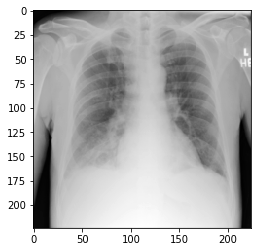

In [15]:
def join_str_array_to_labels(str_array,labels):
    return ','.join(['\n{}: {}'.format(
                                          labels[index_element], 
                                          str_array_element
                                        ) 
                for index_element, str_array_element in enumerate(str_array)])

#show how unbalanced dataset is
frequencies = np.sum(train_dataset_ex1.targets, axis = 0)/len(train_dataset_ex1)
text_frequencies = ['{:.2f}%'.format(frequency*100) for frequency in frequencies]                    
print('Percentage of positive examples for each class in the training set: ')
print(join_str_array_to_labels(text_frequencies, train_dataset_ex1.get_labels_name()))

#plot a few images
print('\n\nShowing one example from the dataset:')
plt.imshow(train_dataset_ex1[1][0].cpu().numpy()[0,:,:], cmap = 'gray')
print(join_str_array_to_labels(train_dataset_ex1[1][1],train_dataset_ex1.get_labels_name()))


#### Defining a scoring function for this exercise

In [16]:
#defining the function that calculates auc from a pair of arrays
def auroc(logits_predicted, target):
    series0, series1, _ = roc_curve(target, logits_predicted)
    return auc(series0, series1)

# defining the function that calculates the AUC score for exercise 1
# one of the inputs should be a model with which inference is made
# the model should have one array with 14 elements as output, and each output should be a score
# the highest this score is, the highest the probability of this class being present in the image
# the other input is a pytorch data loader for whatever set of data for which you want to get a score
def get_score_model_chestxray_binary_model(model, data_loader):
    #toggle model to eval mode
    model.eval()
    
    #turn off gradients since they will not be used here
    # this is to make the inference faster
    with torch.no_grad():
        
        logits_predicted = np.zeros([0, 14])
        targets = np.zeros([0, 14])
        #run through several batches, does inference for each and store inference results
        # and store both target labels and inferenced scores 
        for image, target in data_loader:
            image = image.cuda()
            logit_predicted = model(image)
            logits_predicted = np.concatenate((logits_predicted, logit_predicted.cpu().detach().numpy()), axis = 0)
            targets = np.concatenate((targets, target.cpu().detach().numpy()), axis = 0)
            
    #returns a list of scores, one for each of the labels
    return [auroc(logits_predicted[:,i], targets[:,i]) for i in range(14)]

**Q 1.1 (22 points)**: Modify the resnet18 model provided in the torchvision package from PyTorch (https://pytorch.org/docs/stable/torchvision/models.html#id3) to output 14 binary classifiers, and train it on the ChestXray14 dataset. Justify your choice of loss function. Get an AUC of at least 0.725 on the validation set. You should average the AUC of the 14 classes to get a single AUC score. After getting the desired accuracy, test your best model on the test set, and specify for which anomaly/label your model got its best score and for which anomaly/label your model got its worst score. 

Epoch: 0
Loss: 0.17039916469889171
Trainig Score: 0.7667727973173905
Validation Score: 0.709897373473243
Epoch: 1
Loss: 0.15786714822811596
Trainig Score: 0.7927469380446556
Validation Score: 0.7164852760772668
Epoch: 2
Loss: 0.15354273055948445
Trainig Score: 0.8221562895450409
Validation Score: 0.7319626126686664
New Best Model Saved!
Epoch: 3
Loss: 0.14724831706765346
Trainig Score: 0.8637238837605458
Validation Score: 0.7398084155701303
New Best Model Saved!
Epoch: 4
Loss: 0.1397199363210949
Trainig Score: 0.8946676944925148
Validation Score: 0.7263800424214663
Epoch: 5
Loss: 0.1288171928060257
Trainig Score: 0.9324606995671312
Validation Score: 0.7105072724775522
Epoch: 6
Loss: 0.11074322132488429
Trainig Score: 0.9641481757319014
Validation Score: 0.6964507528590953
Epoch: 7
Loss: 0.08423999319389715
Trainig Score: 0.9882876275435555
Validation Score: 0.6898720076622338
Epoch: 8
Loss: 0.05559720489338545
Trainig Score: 0.9956753034859586
Validation Score: 0.6945708554436799
Epoch

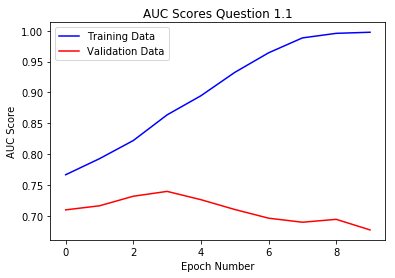

In [17]:
# Replacement module for fully connected layer
# Wanted sigmoid to be part of layer so output is values between 0 and 1
class FullyConnectedReplacement(torch.nn.Module):
    def __init__(self):
        super(FullyConnectedReplacement, self).__init__()
        self.linear = torch.nn.Linear(in_features = 512, out_features = 14)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x
    
# Get data loaders 
b_size = 15
train_loader = torch.utils.data.DataLoader(train_dataset_ex1, shuffle = True, batch_size = b_size, num_workers = 8)
val_loader = torch.utils.data.DataLoader(val_dataset_ex1, batch_size = b_size, num_workers = 8)

# Get resnet model and change the fc layer to output 14 predictions
# Send model to GPU
resnet_model = models.resnet18(pretrained = True)
resnet_model.fc = FullyConnectedReplacement()
resnet_model = resnet_model.cuda()

# Define Loss and optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.0005)

# Training
val_scores = []
train_scores = []
number_of_epochs = 10
target_score = 0.725
best_score = 0
best_model = copy.deepcopy(resnet_model)
for epoch in range(number_of_epochs):
    print('Epoch: ' + str(epoch))
    
    # Toggle to training mode
    resnet_model.train()

    losses = []
    for images, targets in train_loader:
        # Zero out optimizer
        optimizer.zero_grad()
        # Send data to GPU
        images = images.cuda()
        targets = targets.cuda()
        # Get model prediction
        out = resnet_model(images)
        # Calculate loss
        loss = criterion(out, targets)
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()
        # Track losss
        losses.append(loss.item())
    
    # Print mean loss for this epoch
    print('Loss: ' + str(np.mean(losses)))
    
    # Get training data accuracy
    train_score = get_score_model_chestxray_binary_model(resnet_model, train_loader)
    mean_train_score = np.mean(train_score)
    print('Trainig Score: ' + str(mean_train_score))
    train_scores.append(mean_train_score)
    
    # Get validation data accuracy
    val_score = get_score_model_chestxray_binary_model(resnet_model, val_loader)
    mean_val_score = np.mean(val_score)
    print('Validation Score: ' + str(mean_val_score))
    val_scores.append(mean_val_score)
    
    # Save Best Model
    if mean_val_score > target_score and mean_val_score > best_score:
        best_score = mean_val_score
        best_model = copy.deepcopy(resnet_model)
        print('New Best Model Saved!')
    
# Plot Training and Validation AUC Score vs Epoch Number
plt.plot(range(number_of_epochs), train_scores, 'b', range(number_of_epochs), val_scores, 'r')
plt.title('AUC Scores Question 1.1')
plt.legend(['Training Data', 'Validation Data'])
plt.xlabel('Epoch Number')
plt.ylabel('AUC Score')
plt.show()

In [18]:
# Predictions on Test Dataset
test_loader = torch.utils.data.DataLoader(test_dataset_ex1, batch_size = b_size, num_workers = 8)
auc_score_test = get_score_model_chestxray_binary_model(best_model, test_loader)
print('Conditions are Scores')
print(join_str_array_to_labels(auc_score_test, test_dataset_ex1.get_labels_name()))

print('\nMax Score: ' + str(max(auc_score_test)))
print('Min Score: ' + str(min(auc_score_test)))

Conditions are Scores

Atelectasis: 0.7446304175775955,
Cardiomegaly: 0.9029415653888228,
Effusion: 0.827691637945035,
Infiltration: 0.690265649981552,
Mass: 0.7029843304302488,
Nodule: 0.6497070603706636,
Pneumonia: 0.6806380982170785,
Pneumothorax: 0.780121153879155,
Consolidation: 0.7615441226056335,
Edema: 0.827953034760815,
Emphysema: 0.7548574133238669,
Fibrosis: 0.7432812626960267,
Pleural_Thickening: 0.7414967326053493,
Hernia: 0.8137865235539654

Max Score: 0.9029415653888228
Min Score: 0.6497070603706636


### Explanation for Question 1.1

For this question I updated the last layer of the ResNet model to output 14 values followed by a sigmoid to squash the values between 0 and 1. I used the BCELoss function. I chose this function because it uses the binary cross entropy loss which treats each label as an independent binary classifier. In addition the binary cross entropy loss punishes predictions that are confident and wrong; so false positives and false negatives will result in higher loss. Which seems particularly important for medical data.
    


### Analysis for Question 1.1
The anomaly with the best score is Cardiomegaly and the the anomaly with the worst score is Nodule.

The final model used was saved in Epoch 3. The hyperparameters are epochs = 4 (0 indexed), batch_size = 15, and learning_rate = 0.0005.

**Q 1.2 (34 points)**: Build a model of your own design with a maximum of 500,000 parameters that reaches at least 0.67  AUC on the validation set when trained from scratch. You should average the AUC of the 14 classes to get a single AUC score. Besides getting a good score, you should also test several different architectures, methods and hyperparameters, and describe/analyze what worked well and what didn't.

Number of Parameters: 288990
Epoch: 0
Loss: 0.1869866132189646
Trainig Score: 0.5970026409537831
Validation Score: 0.5713881575098109
Epoch: 1
Loss: 0.17450967073693113
Trainig Score: 0.6662079266891912
Validation Score: 0.6253500115413593
Epoch: 2
Loss: 0.17078122606469412
Trainig Score: 0.6882704260811136
Validation Score: 0.6410594449982376
Epoch: 3
Loss: 0.16805327062384556
Trainig Score: 0.7007581994544042
Validation Score: 0.6476220955224362
Epoch: 4
Loss: 0.16599552763341846
Trainig Score: 0.7220229639822738
Validation Score: 0.6655745855613447
Epoch: 5
Loss: 0.16395936483612
Trainig Score: 0.7450592481119094
Validation Score: 0.6796024569950719
New Best Model Saved!
Epoch: 6
Loss: 0.16213086527156628
Trainig Score: 0.7558255974528615
Validation Score: 0.6829095724752928
New Best Model Saved!
Epoch: 7
Loss: 0.16064805511574623
Trainig Score: 0.7680355915991784
Validation Score: 0.685517379560196
New Best Model Saved!
Epoch: 8
Loss: 0.15790138413845484
Trainig Score: 0.7944173708

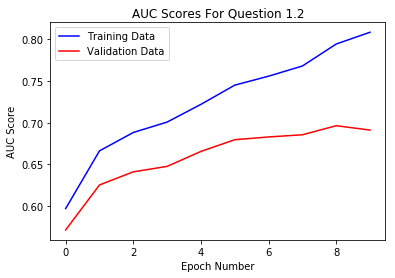

In [19]:
# This class defines a simple convolution block
# A convolution is followed by a non-linearity and a maxpooling
class SimpleBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SimpleBlock, self).__init__()
        # Nonlinearities and max pooling
        self.relu = torch.nn.ReLU()
        self.maxpooling_layer = torch.nn.MaxPool2d(kernel_size = 2)
        
        # Convolution Layers 
        self.convolution_layer_1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size = 5)
        
    def forward(self, x):
        x = self.convolution_layer_1(x)
        x = self.relu(x)
        x = self.maxpooling_layer(x)
        return x
        
# Model Decleration
class ConvNet(torch.nn.Module):
    
    def __init__(self, block):
        super(ConvNet, self).__init__()
        # Convolution Layers
        self.convolution_layer_1 = block(in_channels= 3, out_channels = 8)
        self.convolution_layer_2 = block(8, 16)
        self.convolution_layer_3 = block(16, 32)
        self.convolution_layer_4 = block(32, 64)
        self.convolution_layer_5 = block(64, 128)
        # Linear layer for classification
        self.fully_connected_layer = torch.nn.Linear(in_features = 1152, out_features = 14)
        # Sigmoid to squash between 0 and 1
        self.sigmoid = torch.nn.Sigmoid()
    
    
    def forward(self, x):
        # Layer 1
        x = self.convolution_layer_1(x)
        x = self.convolution_layer_2(x)
        x = self.convolution_layer_3(x)
        x = self.convolution_layer_4(x)
        x = self.convolution_layer_5(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected_layer(x)
        x = self.sigmoid(x)
        return x

# Model Training
# Get data loaders
b_size = 15
train_loader = torch.utils.data.DataLoader(train_dataset_ex1, shuffle = True, batch_size = b_size, num_workers = 8)
val_loader = torch.utils.data.DataLoader(val_dataset_ex1, batch_size = b_size, num_workers = 8)

# Instantiate my_model
# Send model to GPU
my_model = ConvNet(SimpleBlock)
my_model = my_model.cuda()

# Print number of parameters
print('Number of Parameters: ' + str(count_number_parameters(my_model)))

# Define Loss and optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.0005)

# Training
val_scores = []
train_scores = []
number_of_epochs = 10
target_score = 0.67
best_score = 0
best_model = copy.deepcopy(my_model)
for epoch in range(number_of_epochs):
    print('Epoch: ' + str(epoch))
    
    # Toggle to training mode
    my_model.train()

    losses = []
    for images, targets in train_loader:
        # Zero out optimizer
        optimizer.zero_grad()
        # Send data to GPU
        images = images.cuda()
        targets = targets.cuda()
        # Get model prediction
        out = my_model(images)
        # Calculate loss
        loss = criterion(out, targets)
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()
        # Track losss
        losses.append(loss.item())
    
    # Output mean loss for this epoch
    print('Loss: ' + str(np.mean(losses)))
    
    # Get training data accuracy
    train_score = get_score_model_chestxray_binary_model(my_model, train_loader)
    mean_train_score = np.mean(train_score)
    print('Trainig Score: ' + str(mean_train_score))
    train_scores.append(mean_train_score)
    
    # Get validation data accuracy
    val_score = get_score_model_chestxray_binary_model(my_model, val_loader)
    mean_val_score = np.mean(val_score)
    print('Validation Score: ' + str(mean_val_score))
    val_scores.append(mean_val_score)
    
    # Save best model
    if mean_val_score > target_score and mean_val_score > best_score:
        best_score = mean_val_score
        best_model = copy.deepcopy(my_model)
        print('New Best Model Saved!')
    
# Plot Training and Validation AUC Score vs Epoch Number
plt.plot(range(number_of_epochs), train_scores, 'b', range(number_of_epochs), val_scores, 'r')
plt.title('AUC Scores For Question 1.2')
plt.legend(['Training Data', 'Validation Data'])
plt.xlabel('Epoch Number')
plt.ylabel('AUC Score')
plt.show()

In [20]:
# Predictions on Test Dataset Using my model
test_loader = torch.utils.data.DataLoader(test_dataset_ex1, batch_size = b_size, num_workers = 8)
auc_score_test = get_score_model_chestxray_binary_model(best_model, test_loader)
print(join_str_array_to_labels(auc_score_test, test_dataset_ex1.get_labels_name()))

print('\nMax Score: ' + str(max(auc_score_test)))
print('Min Score: ' + str(min(auc_score_test)))


Atelectasis: 0.7155952968648377,
Cardiomegaly: 0.7992875489359315,
Effusion: 0.7875031578757422,
Infiltration: 0.6782991022014513,
Mass: 0.614584519750846,
Nodule: 0.575978735865207,
Pneumonia: 0.6416686375184053,
Pneumothorax: 0.6091938900615304,
Consolidation: 0.7522100152172192,
Edema: 0.8569181104936253,
Emphysema: 0.474124363980594,
Fibrosis: 0.7290007719184204,
Pleural_Thickening: 0.6249372286060321,
Hernia: 0.7545617173524151

Max Score: 0.8569181104936253
Min Score: 0.474124363980594


### Explanation for Question 1.2
The model I designed has 288,990 parametrs. It is created by stacking convolution layers, there are five convolution layers total. The convolution layers are comprised of a convolution function, a non-lineraity (relu), and a max-pooling layer; in the analysis section I refer to the as the simple convolution block or simple block. The kernel size for the convoluation layer is five. 

### Analysis for Question 1.2
For the convolution layer I tried kernel sizes of three, five, and seven. A kernel size of five got the best AUC score for the task. I also tried creating a convolution block that had a convolution layer, a relu layer, a convolution layer, a relu layer, and then the max-pooling layer. This convolution block performed worse than the simple block for all kernel sizes. I also tried mixing and matching the kernel sizes for the convolution block with multiple convolution layers; it did not improve. 

Training of my model with the simple block was slow so I tried to increase the learning rate. This reduced the AUC score for both training and validation data. I still used the BCELoss and Adam optimizer because that gave me the best results in question 2.1 and for the reasons explalined in the explanation section for that question.

# Exercise 2: RSNA Pneumonia Detection Challenge
**(44 points total)**

In this exercise we will be using a dataset from Kaggle. Kaggle is a website that hosts machine learning competitions and datasets, and is a great resource for finding interesting projects for practicing deep learning concepts. You will have to create a Kaggle account to access the dataset for this exercise. You will need to register for this Kaggle competition (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge), accept the terms, and get an API key for your account on Kaggle. To get this key, you should do:

- click on your image on the upper right corner of a Kaggle webpage
- click on "My Account"
- click on the button "Create New API Token"
- Save the key inside the json file somewhere.

Below you will be asked for this key, so that a script can connect to the Kaggle databases and download the files to your system. 

The dataset for this exercise is a dataset which has images labeled as having pneumonia or not and, for each image with pneumonia, bounding boxes are provided to know where the evidence for pneumonia is in the image. The original dataset is evaluated as an object detection task, by mean average precision of bounding boxes (more details here, if you are curious: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge#evaluation ). Some famous models predict bounding boxes directly (https://pjreddie.com/darknet/yolo/, for example). However, we are going to simplify the task and convert the ground truth bounding boxes to a grid of binary labels, train a model using these modified labels, and use the AUC metric to evaluate them. 

**Important:** Please download the file **image_names_kaggle_pneumonia.csv** provided with the assignment and put it in the same directory as this notebook. If you are using Google Colaboratory, use the python command ```files.upload()``` below to upload the file.

#### Getting the dataset and defining loading and processing  steps

In [21]:
# If you are using Google Colaboratory, use the next line to upload the image_names_kaggle_pneumonia.csv file
# else put it in the same folder as this notebook
if machine_being_used == 'colab':
    files.upload()

In [22]:
#getting Kaggle username for the API connection
print("Write your kaggle username:")
kaggle_username = getpass.getpass()

Write your kaggle username:
········


In [23]:
#getting Kaggle API key for the API connection
#check Exercise 2 for how to get this key
print("Write your kaggle key:")
kaggle_key = getpass.getpass()

Write your kaggle key:
········


In [24]:
if pneumonia_dataset_folder!='/scratch/tmp/deep_learning_datasets_ECE_6960_013/kaggle_pneumonia':
    #downloading the dataset
    os.environ['KAGGLE_USERNAME']=kaggle_username
    os.environ['KAGGLE_KEY']=kaggle_key
    os.makedirs(pneumonia_dataset_folder, exist_ok=True)
    !kaggle competitions download -c rsna-pneumonia-detection-challenge -p $pneumonia_dataset_folder

In [25]:
if pneumonia_dataset_folder!='/scratch/tmp/deep_learning_datasets_ECE_6960_013/kaggle_pneumonia':
    #extracting the dataset
    c1 = pneumonia_dataset_folder+'/stage_2_train_images.zip'
    d1 = pneumonia_dataset_folder+'/stage_2_train_images'
    e1 = pneumonia_dataset_folder+'/stage_2_train_labels.csv.zip'

    !unzip -n $c1 -d $d1
    !unzip -n $e1 -d $pneumonia_dataset_folder

In [26]:
# creating a pytorch dataset class
# it contains the data reading, indexing and preprocessing for the RSNA pneumonia localization dataset
class RSNAPneumoniaDetectionDataset(Dataset):
    
    # defining a function that receives a list of bounding boxes and transform it 
    # into a spatial grid of positive and negative labels, positive labels corresponding to
    # the bounding boxes locations
    def get_grid(self, bounding_boxes):
        #images of this dataset are 1024x1024 pixels
        image_original_size = 1024
        
        
        grid_size = self.grid_size
        
        # start by creating a grid with the same size as the original image
        # since it is easy to know how each bounding box should be translated to 0/1 
        # grid cells
        # set as 1 cells inside bounding boxes, and 0 cells outside bounding boxes
        this_grid = torch.zeros([1,1,image_original_size,image_original_size], dtype = torch.float)
        for bounding_box in bounding_boxes:
            if bounding_box[0]!=bounding_box[0]:
                continue
            y1 = int(bounding_box[1])
            y2 = y1 + int(bounding_box[3])
            x1 = int(bounding_box[0])
            x2 = x1 + int(bounding_box[2])
            this_grid[:,:,y1:y2, x1:x2] = 1.0
        
        #reduce the image to a size that is a multiple of the grid size, to be able to 
        # use average pooling with well defined kernel cells
        first_resize_size = (image_original_size//self.grid_size)*self.grid_size
        this_grid = torch.nn.functional.interpolate(this_grid, size = (first_resize_size, first_resize_size), mode = 'bilinear', align_corners = False)
        this_grid = torch.nn.AvgPool2d(kernel_size = image_original_size//grid_size)(this_grid)
        
        #this_grid now should contain a number from 0 to 1 specifying how much of that particular cell
        #is being occupied by a bounding box
        
        # only set as positive labeled the cells that had more than 50% of its area 
        # occupied by bounding boxes
        this_grid = ((this_grid[0,:,:,:][:]>0.5)*1.0).float()
        return this_grid
    
    #split can be 'train', 'val', and 'test'
    def __init__(self, path_dataset_folder, grid_size, split = 'train'):
        self.path_image_folder = path_dataset_folder + '/stage_2_train_images'
        self.grid_size = grid_size
        
        #get the filenames of all images inside the dataset
        all_images_list = !find $self.path_image_folder -type f -name "*.dcm" |sed 's#.*/##' | sed 's/\.[^.]*$//'

        #read the labels file
        label_filename = path_dataset_folder + '/stage_2_train_labels.csv'
        label_file = pd.read_csv(label_filename)
        
        # getting the list of all patient ids present in the dataset, to split into
        # training, validation and testing by patient id
        all_images_list =  pd.read_csv('image_names_kaggle_pneumonia.csv')['patientId'].values

        all_images_list = pd.DataFrame(get_split(all_images_list, split), columns = ['patientId'])
        
        examples_to_use = pd.merge(all_images_list, label_file)
        
        # put all bounding boxes coordinates as a list of coordinates in a single column    
        dataframe_with_listed_bounding_boxes = examples_to_use
        dataframe_with_listed_bounding_boxes['x'] = dataframe_with_listed_bounding_boxes['x'].apply(lambda x: [x])
        dataframe_with_listed_bounding_boxes['y'] = dataframe_with_listed_bounding_boxes['y'].apply(lambda x: [x])
        dataframe_with_listed_bounding_boxes['width'] = dataframe_with_listed_bounding_boxes['width'].apply(lambda x: [x])
        dataframe_with_listed_bounding_boxes['height'] = dataframe_with_listed_bounding_boxes['height'].apply(lambda x: [x])
        dataframe_with_listed_bounding_boxes['bounding_boxes'] = dataframe_with_listed_bounding_boxes['x'] + \
                                                                dataframe_with_listed_bounding_boxes['y'] + \
                                                                dataframe_with_listed_bounding_boxes['width'] + \
                                                                dataframe_with_listed_bounding_boxes['height']
        dataframe_with_listed_bounding_boxes = dataframe_with_listed_bounding_boxes[['patientId', 'bounding_boxes']]
        
        # Since bounding boxes for the same patient id are stored in more than one label line, 
        # group them by patient id and create a list of bounding boxes for each patient id
        dataframe_with_listed_bounding_boxes = dataframe_with_listed_bounding_boxes.groupby('patientId')
        dataframe_with_listed_bounding_boxes = dataframe_with_listed_bounding_boxes.aggregate(lambda x: tuple(x)).reset_index()
        
        # transform all lists of bounding boxes to grids
        dataframe_with_listed_bounding_boxes['bounding_boxes'] = dataframe_with_listed_bounding_boxes['bounding_boxes'].apply(lambda x: self.get_grid(x))
        
        #join the tables with targets and grids
        examples_to_use = examples_to_use[['patientId', 'Target']].drop_duplicates()
        examples_to_use = pd.merge(examples_to_use, dataframe_with_listed_bounding_boxes)
        assert(len(examples_to_use) == len(all_images_list))
        
        self.image_list = examples_to_use['patientId'].values
        self.targets = examples_to_use['Target'].values
        self.grids = examples_to_use['bounding_boxes'].values
        
    def __getitem__(self, index):
        #defining the transformations to do to the images before feeding it to the deep learning model
        #these include cropping it to a square, resizing it to the usual ImageNet used size, transform it into a pytorch
        # tensor, and normalizing it using the ImageNet dataset average and standard deviation per channel
        set_of_transforms = transforms.Compose(
        [CropBiggestCenteredInscribedSquare(),
         transforms.Resize(224),
         transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
        image_to_return = set_of_transforms(Image.fromarray(pydicom.dcmread(self.path_image_folder + '/' + self.image_list[index] + '.dcm').pixel_array))
        
        #the first element of the returned elements is a 3-channel image stored in a pytorch tensor
        # the second element is a single binary label specifying the target label for that image, 
        # the third element is a 1-channel spatial grid specifying coarsely where in the image positive labels are present
        return image_to_return, torch.FloatTensor(self.targets[index:index + 1]), torch.FloatTensor(self.grids[index])
    
    def __len__(self):
        return len(self.image_list)

#### Setting the variables that you should use as datasets for Exercise 1

In [27]:
#creating the datasets to be used in exercise 2
# this may take a few minutes
train_dataset_ex2 = RSNAPneumoniaDetectionDataset(pneumonia_dataset_folder, grid_size  = 14)
val_dataset_ex2 = RSNAPneumoniaDetectionDataset(pneumonia_dataset_folder, split = 'val', grid_size  = 14)
test_dataset_ex2 = RSNAPneumoniaDetectionDataset(pneumonia_dataset_folder, split = 'test', grid_size  = 14)

# if any of the following asserts fail, please contact the TA
assert(len(train_dataset_ex2) == 16010)
assert(len(val_dataset_ex2) == 5337)
assert(len(test_dataset_ex2) == 5337)
assert(sum(train_dataset_ex2.targets) == 3603)
assert(sum(val_dataset_ex2.targets) == 1195)
assert(np.sum([grid.numpy() for grid in train_dataset_ex2.grids]) == 81251)

#### Short visualization of the resulting dataset

Percentage of positive examples for whole images: 22.50%
Percentage of positive examples for grid cells: 2.59%

Visualizing a few examples: 
Label pneumonia: 1.0


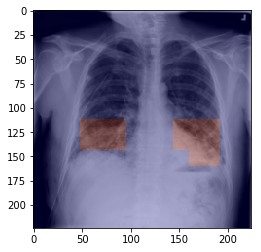

Label pneumonia: 1.0


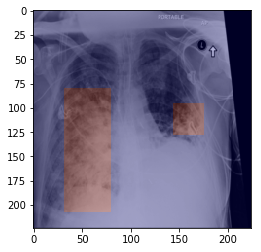

Label pneumonia: 0.0


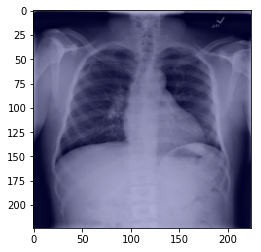

In [28]:
#show how unbalanced dataset is
frequency = np.sum(train_dataset_ex2.targets, axis = 0)/len(train_dataset_ex2)
                
print('Percentage of positive examples for whole images: ' + '{:.2f}'.format(frequency*100) + '%')


frequency = np.sum([grid.numpy() for grid in train_dataset_ex2.grids])/len(train_dataset_ex2)/14/14
print('Percentage of positive examples for grid cells: ' + '{:.2f}'.format(frequency*100) + '%')

def imresize(arr, size, resample):
    return np.array(Image.fromarray(arr).resize(size, resample))

def plot_grid_over_xray(example):
    image = example[0].numpy()[0,:,:]
    print('Label pneumonia: ' + str(example[1][0].cpu().numpy()))
    max1 = np.max(image)
    min1 = np.min(image)
    fig, ax = plt.subplots()
    ax.imshow((image-min1)/(max1 - min1), cmap = 'gray')
    ax.imshow(imresize(example[2].numpy()[0,:,:], (224, 224), resample  = Image.NEAREST), cmap='jet', alpha=0.3, resample = True)
    plt.show()

print('\nVisualizing a few examples: ')
#plot a few images from the dataset
# reddish areas mean ones in the grid (pneumonia presence)
#blueish areas mean zeros in the grid (pneumonia absence)
plot_grid_over_xray(train_dataset_ex2[1])
plot_grid_over_xray(train_dataset_ex2[10])
plot_grid_over_xray(train_dataset_ex2[0])

#### Defining scoring functions for this exercise

In [29]:
# defining one of the functions that calculate the AUC score for exercise 2
# it calculates the score for a model that outputs a spatial grid of scores, for the task
# of localizing where in an image there is evidence for pneumonia
# one of the inputs of this function should be a model with which inference is made
# the model should have one single score as output
# the highest this score is, the highest the probability of this grid cell having evidence for pneumonia
# the other input is a pytorch data loader for whatever set of data for which you want to get a score
def get_score_model_pneumonia_location_model(model, data_loader):
    #toggle model to eval mode
    model.eval()
    
    #turn off gradients since they will not be used here
    # this is to make the inference faster
    with torch.no_grad():
        logits_predicted = np.zeros([0, 1])
        targets = np.zeros([0,1])
        #run through several batches, does inference for each and store inference results
        # and store both target labels and inferenced scores 
        for image, target, grid in data_loader:
            image = image.cuda()
            logit_predicted = model(image)
            # each grid cell target is considered a different example for calculating the score
            # for that, all outputs and target are reshaped to have only one value in the second dimension
            logits_predicted = np.concatenate((logits_predicted, logit_predicted.view([-1,1]).cpu().numpy()), axis = 0)
            targets = np.concatenate((targets, grid.view([-1,1]).cpu().numpy()), axis = 0)
    return auroc(logits_predicted[:,0], targets[:,0])

In [30]:
# defining one of the functions that calculate the AUC score for exercise 2
# it calculates the score for a model that outputs a single score for the task of classifying
# if an image contains evidence for pneumonia or not.
# one of the inputs should be a model with which inference is made
# the model should have one single score as output
# the highest this score is, the highest the probability of this grid cell having evidence for pneumonia
# the other input is a pytorch data loader for whatever set of data for which you want to get a score
def get_score_model_pneumonia_binary_model(model, data_loader):
    #toggle model to eval mode
    model.eval()
    
    #turn off gradients since they will not be used here
    # this is to make the inference faster
    with torch.no_grad():
        logits_predicted = np.zeros([0,1])
        targets = np.zeros([0,1])
        
        #run through several batches, does inference for each and store inference results
        # and store both target labels and inferenced scores 
        for image, target, grid in data_loader:
            image = image.cuda()
            logit_predicted = model(image)
            logits_predicted = np.concatenate((logits_predicted, logit_predicted.cpu().numpy()), axis = 0)
            
            targets = np.concatenate((targets, target.cpu().numpy()), axis = 0)
    return auroc(logits_predicted, targets)

In [33]:
# defining one of the functions that calculate the AUC score for exercise 2
# it calculates the score for a model that outputs a grid of scores, but this grid is converted
# to a single number to adapt this score to the binary task of saying if the whole image
# has evidence for pneumonia or not
# one of the inputs should be a model with which inference is made
# the model should have one array with 196 (14x14) elements as output, and each output should be a score
# the highest this score is, the highest the probability of this grid cell having evidence for pneumonia
# the other input is a pytorch data loader for whatever set of data for which you want to get a score
def get_score_model_pneumonia_binary_with_location_model(model, data_loader):
    #toggle model to eval mode
    model.eval()
    
    #turn off gradients since they will not be used here
    # this is to make the inference faster
    with torch.no_grad():
        logits_predicted = np.zeros([0,1])
        targets = np.zeros([0,1])
        
        #run through several batches, does inference for each and store inference results
        # and store both target labels and inferenced scores 
        for image, target, grid in data_loader:
            image = image.cuda()
            logit_predicted = model(image)
            
            # to convert a grid of labels to a single binary logit, we take the maximum logit 
            # in the grid. We do this since having only one grid cell labeled as positive means the whole
            # image should be labeled as having pneumonia.
            logits_predicted = np.concatenate((logits_predicted, torch.max(logit_predicted.view(logit_predicted.shape[0], -1),dim = 1)[0].view(-1,1).cpu().numpy()), axis = 0)
            targets = np.concatenate((targets, target.cpu().numpy()), axis = 0)
    return auroc(logits_predicted[:,0], targets[:,0])

**Q 2.1 (22 points)**: Modify the resnet18 model from PyTorch to output a flattened 14x14 grid, and train it on the pneumonia dataset to get an AUC of at least 0.97 in the validation set. The output of layer3 in the resnet18 model is already 14x14, so you should remove layer4 from the model and use the output of layer3. After getting the desired accuracy, test your best model on the test set. Select a few test examples for which your model got the locations correctly and a few examples with mistakes. Comment and show a visualization for them.

Epoch: 0
Loss: 0.08546554731389976
Trainig Score: 0.9669067732483191
Validation Score: 0.9661151311989511
Epoch: 1
Loss: 0.061310876108102555
Trainig Score: 0.9683641670589473
Validation Score: 0.9660746582441346
Epoch: 2
Loss: 0.05836908977211903
Trainig Score: 0.9760444529616101
Validation Score: 0.9701624343656022
New Best Model Saved!
Epoch: 3
Loss: 0.056320159947185706
Trainig Score: 0.9767963881846643
Validation Score: 0.9675459929758854
Epoch: 4
Loss: 0.05392707253488876
Trainig Score: 0.982094893424269
Validation Score: 0.9712970627161702
New Best Model Saved!
Epoch: 5
Loss: 0.05004798189635748
Trainig Score: 0.9851388807066868
Validation Score: 0.9664434190905145
Epoch: 6
Loss: 0.045585336967210954
Trainig Score: 0.9873640337438702
Validation Score: 0.9661420665011735
Epoch: 7
Loss: 0.03823763297409454
Trainig Score: 0.9935378544779253
Validation Score: 0.9639242233018562
Epoch: 8
Loss: 0.030643885212140298
Trainig Score: 0.9953420810597894
Validation Score: 0.9597062632661197

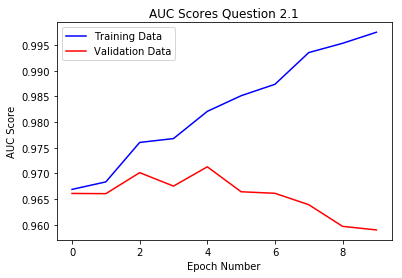

In [34]:
# This class replaces layer four in the ResNet model
# A convolution that reduces channel only
class LayerFourReplacement(torch.nn.Module):
    def __init__(self):
        super(LayerFourReplacement, self).__init__()
        self.convolution_layer_1 = torch.nn.Conv2d(in_channels = 256, out_channels = 1, kernel_size=1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.convolution_layer_1(x)
        x = self.sigmoid(x)
        return x
        
        
# Defint batch size
b_size = 15
# Get data loaders
train_loader = torch.utils.data.DataLoader(train_dataset_ex2, shuffle = True, batch_size = b_size, num_workers = 8)
val_loader = torch.utils.data.DataLoader(val_dataset_ex2, batch_size = b_size, num_workers = 8)

# Get resnet model 
# Send model to GPU
resnet_model = models.resnet18(pretrained = True)
resnet_model.layer4 = LayerFourReplacement()
resnet_model.avgpool = torch.nn.Sequential()
resnet_model.fc = torch.nn.Sequential()
resnet_model = resnet_model.cuda()

# Define Loss and optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.0005)

# Training
val_scores = []
train_scores = []
number_of_epochs = 10
target_score = 0.97
best_score = 0
best_model = copy.deepcopy(resnet_model)
for epoch in range(number_of_epochs):
    print('Epoch: ' + str(epoch))
    
    # Toggle to training mode
    resnet_model.train()

    losses = []
    for images, targets, grids in train_loader:
        # Zero out optimizer
        optimizer.zero_grad()
        # Send data to GPU
        images = images.cuda()
        targets = targets.cuda()
        grids = grids.cuda()
        # Get model prediction
        out = resnet_model(images)
        # Calculate loss
        loss = criterion(out, grids.view(grids.size(0), -1))
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()
        # Track losss
        losses.append(loss.item())
    
    # Output mean loss for this epoch
    print('Loss: ' + str(np.mean(losses)))
    
    # Get training data accuracy
    train_score = get_score_model_pneumonia_location_model(resnet_model, train_loader)
    mean_train_score = np.mean(train_score)
    print('Trainig Score: ' + str(mean_train_score))
    train_scores.append(mean_train_score)
    
    # Get validation data accuracy
    val_score = get_score_model_pneumonia_location_model(resnet_model, val_loader)
    mean_val_score = np.mean(val_score)
    print('Validation Score: ' + str(mean_val_score))
    val_scores.append(mean_val_score)
    
    # Save Best Model
    if mean_val_score > target_score and mean_val_score > best_score:
        best_score = mean_val_score
        best_model = copy.deepcopy(resnet_model)
        print('New Best Model Saved!')
    
# Plot Training and Validation AUC Score vs Epoch Number
plt.plot(range(number_of_epochs), train_scores, 'b', range(number_of_epochs), val_scores, 'r')
plt.title('AUC Scores Question 2.1')
plt.legend(['Training Data', 'Validation Data'])
plt.xlabel('Epoch Number')
plt.ylabel('AUC Score')
plt.show()

### AUC Score for Test Data

In [35]:
# Predictions on Test Dataset
test_loader = torch.utils.data.DataLoader(test_dataset_ex2, batch_size = 15, num_workers = 8)
auc_score_test = get_score_model_pneumonia_location_model(best_model, test_loader)
print('Test AUC Score: ' + str(auc_score_test))



Test AUC Score: 0.9708770709946217


### Visualization of Results

Examples of Good Predictions
Example 0:
Ground Truth


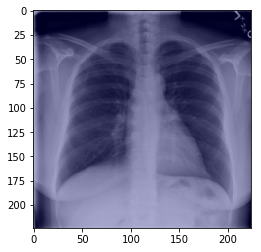

Prediction


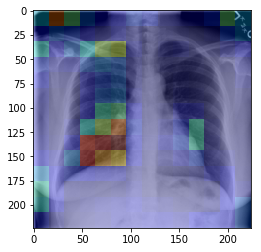

Example 1:
Ground Truth


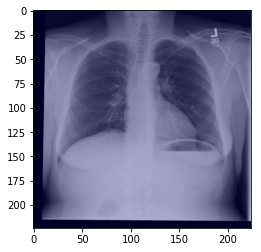

Prediction


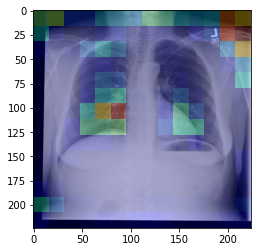

Example 2:
Ground Truth


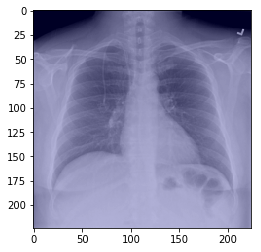

Prediction


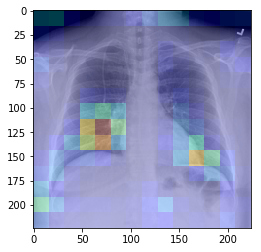

Examples of Poor Predictions
Example 0:
Ground Truth


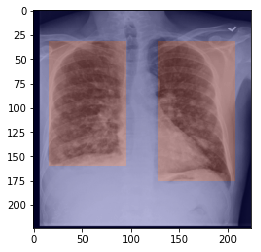

Prediction


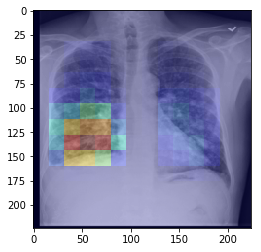

Example 1:
Ground Truth


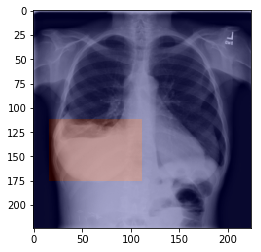

Prediction


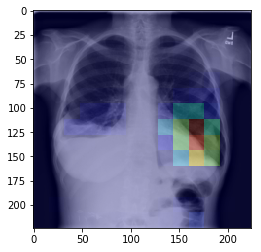

Example 2:
Ground Truth


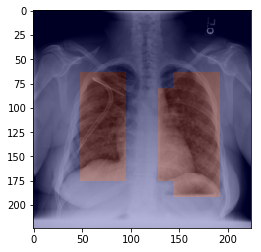

Prediction


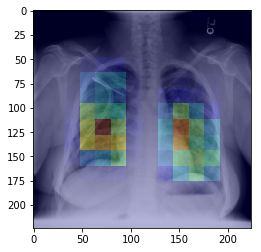

In [36]:
# This class is used to hold a prediction and its ground truth
class Prediction:
    def __init__(self, loss, image, target, grid, logit):
        super(Prediction, self).__init__()
        self.loss = loss
        self.image = image
        self.target = target
        self.grid = grid
        self.logit = logit

# New predictions are compared to the current
# list of worst predictions and the list is updated accordingly
def get_worst(current_worst, new_prediction, list_size = 3):
    if len(current_worst) < list_size:
        current_worst.append(new_prediction)
    else:    
        for worst in current_worst:
            if new_prediction.loss > worst.loss :
                current_worst[current_worst.index(worst)] = new_prediction
                return current_worst
    return current_worst

# New predictions are compared to the current
# list of best predictions and the list is updated accordingly
def get_best(current_best, new_prediction, list_size = 3):
    if len(current_best) < list_size:
        current_best.append(new_prediction)
    else:    
        for best in current_best:
            if new_prediction.loss < best.loss :
                current_best[current_best.index(best)] = new_prediction
                return current_best
    return current_best    

# Gets lists of three worst and three best predictions
# Best is defined as those prediction with the smallest loss
def get_examples(model, data_loader):
    #toggle model to eval mode
    model.eval()
    three_worst = []
    three_best = []
    
    with torch.no_grad():
        criterion = torch.nn.BCELoss()
        count = 0;
        for image, target, grid in data_loader:
            image = image.cuda()
            target = target.cuda()
            grid = grid.cuda()
            
            logit_predicted = model(image)
            loss = criterion(logit_predicted, grid.view(grid.size(0), -1))
            
            prediction = Prediction(loss, image.view(3, 224, 224), target, grid.view(1, 14, 14), logit_predicted.view(1, 14, 14))
            three_worst = get_worst(three_worst, prediction)
            three_best = get_best(three_best, prediction)

    return three_worst, three_best

# Plots the grid, predicted or ground truth, over the image
def plot_grid_over_xray(image, target, grid):
    image = image.cpu().numpy()[0,:,:]
    max1 = np.max(image)
    min1 = np.min(image)
    fig, ax = plt.subplots()
    ax.imshow((image-min1)/(max1 - min1), cmap = 'gray')
    ax.imshow(imresize(grid.cpu().numpy()[0,:,:], (224, 224), resample  = Image.NEAREST), cmap='jet', alpha=0.3, resample = True)
    plt.show()
    

# Test loader that gets a single image at a time and compares it to ground truth,
# This is used to find the best and worst predictions
test_loader = torch.utils.data.DataLoader(test_dataset_ex2, shuffle = True, batch_size = 1, num_workers = 8)
worst, best = get_examples(best_model, test_loader)

# Display Images
print('Examples of Good Predictions')
for i, b in enumerate(best):
    print('Example ' + str(i) + ':')
    print('Ground Truth')
    plot_grid_over_xray(b.image, b.target, b.grid)
    print('Prediction')
    plot_grid_over_xray(b.image, b.target, b.logit)

print('Examples of Poor Predictions')
for i, w in enumerate(worst):
    print('Example ' + str(i) + ':')
    print('Ground Truth')
    plot_grid_over_xray(w.image, w.target, w.grid)
    print('Prediction')
    plot_grid_over_xray(w.image, w.target, w.logit)

### Analysis for Question 2.1
Above are the visualziations for my three best and three worst test set predictions. In the three best predictions the patient does not have pneumonia. In the three worst predictions the patient does have pneumonia. In the worst case the prediction boxes are present, however there are lots of light blue and green boxes, which correlate with values less than one. The boxes in the ground truth images are dark orange which correlates with the value 1. It appears that in these images the model is returning grids with a low probability for cancer in the correct location when it should be returning a high probability in the same location.


#### Number of parameters for Question 2.1 Model

In [37]:
print(count_number_parameters(best_model))

2783041


**Q 2.2 (22 points)**: Modify the resnet18 model from PyTorch to have a single output and the same number of parameters of your model in question 2.1. For training this model, you are only allowed to use the pneumonia binary target for the whole image as ground truth, and you are not allowed to use the grid target. You should be able to achieve an AUC of at least 0.865.

Also train a model just like the one from question 2.1, this time validating with a score for the binary task of presence or absence of pneumonia on an image. This score is calculated by the function ```get_score_model_pneumonia_binary_with_location_model```. When converting from a grid to a single output, this function considers that the probability of an image having pneumonia is the maximum probability over the grid.

Compare both models on their scores for the binary task. Analyze why you got these results. Test your best model for the binary task on the test set.

### Binary with Single Output

Number of Parameters for second part Q 2.2 Model: 2783041
Epoch: 0
Loss: 0.4340354881985357
Trainig Score: 0.8502630204301462
Validation Score: 0.8421416290717196
Epoch: 1
Loss: 0.3947968818526366
Trainig Score: 0.8642846994796993
Validation Score: 0.8463177491923737
Epoch: 2
Loss: 0.3815088151197197
Trainig Score: 0.8593964071878791
Validation Score: 0.8454108237081513
Epoch: 3
Loss: 0.37084859802146974
Trainig Score: 0.884650900674932
Validation Score: 0.8655758239404892
New Best Model Saved!
Epoch: 4
Loss: 0.3583076299492563
Trainig Score: 0.8941445363775711
Validation Score: 0.8638846069147765
Epoch: 5
Loss: 0.3450350272312258
Trainig Score: 0.9060078647641926
Validation Score: 0.8643048352523087
Epoch: 6
Loss: 0.3292491513266043
Trainig Score: 0.9195923639124602
Validation Score: 0.860607229947734
Epoch: 7
Loss: 0.31043436896572174
Trainig Score: 0.9370261064831367
Validation Score: 0.8623329945915804
Epoch: 8
Loss: 0.2786817147853446
Trainig Score: 0.9545777173902953
Validation S

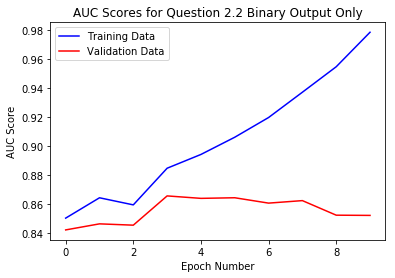

In [38]:
# This class replaces layer four in the ResNet model
# A convolution that reduces channel only
class LayerFourReplacement(torch.nn.Module):
    def __init__(self):
        super(LayerFourReplacement, self).__init__()
        self.convolution_layer_1 = torch.nn.Conv2d(in_channels = 256, out_channels = 1, kernel_size=1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.convolution_layer_1(x)
        x = self.sigmoid(x)
        return x

# This class replaces the fully connected layer in the resnet model
# It takes the max value for the grid
class FullyConnectedReplacement(torch.nn.Module):
    def __init__(self):
        super(FullyConnectedReplacement, self).__init__()
               
    def forward(self, x):
        x = torch.max(x, dim = 1)
        x = x[0]
        x = x.view(-1, 1)
        return x
    
# Resnet - binary target
# Create data loaders for data
b_size = 15
train_loader = torch.utils.data.DataLoader(train_dataset_ex2, shuffle = True, batch_size = b_size, num_workers = 8)
val_loader = torch.utils.data.DataLoader(val_dataset_ex2, batch_size = b_size, num_workers = 8)

# Get resnet model and change the output features to 14
# Send model to GPU
resnet_model = models.resnet18(pretrained = True)
resnet_model.layer4 = LayerFourReplacement()
resnet_model.avgpool = torch.nn.Sequential()
resnet_model.fc = FullyConnectedReplacement()
resnet_model = resnet_model.cuda()
print('Number of Parameters for second part Q 2.2 Model: ' + str(count_number_parameters(resnet_model)))

# Define Loss and optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.0005)

# Training
val_scores = []
train_scores = []
number_of_epochs = 10
target_score = 0.865
best_score = 0
best_model = copy.deepcopy(resnet_model)
for epoch in range(number_of_epochs):
    print('Epoch: ' + str(epoch))
    
    # Toggle to training mode
    resnet_model.train()

    losses = []
    for images, targets, grids in train_loader:
        # Zero out optimizer
        optimizer.zero_grad()
        
        # Send data to GPU
        images = images.cuda()
        targets = targets.cuda()
        grids = grids.cuda()
        
        # Get model output
        out = resnet_model(images)
        # Calculate loss
        loss = criterion(out, targets)
        
        # Backpropigation
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Track losss
        losses.append(loss.item())
    
    # Output mean loss for this epoch
    print('Loss: ' + str(np.mean(losses)))
    
    # Training Accuracy
    train_score = get_score_model_pneumonia_binary_model(resnet_model, train_loader)
    mean_train_score = np.mean(train_score)
    print('Trainig Score: ' + str(mean_train_score))
    train_scores.append(mean_train_score)
    
    # Validation Accuracy
    val_score = get_score_model_pneumonia_binary_model(resnet_model, val_loader)
    mean_val_score = np.mean(val_score)
    print('Validation Score: ' + str(mean_val_score))
    val_scores.append(mean_val_score)
    
    # Save Best Model
    if mean_val_score > target_score and mean_val_score > best_score:
        best_score = mean_val_score
        best_model = copy.deepcopy(resnet_model)
        print('New Best Model Saved!')
    
# Plot Training and Validation AUC Score vs Epoch Number
plt.plot(range(number_of_epochs), train_scores, 'b', range(number_of_epochs), val_scores, 'r')
plt.title('AUC Scores for Question 2.2 Binary Output Only')
plt.legend(['Training Data', 'Validation Data'])
plt.xlabel('Epoch Number')
plt.ylabel('AUC Score')
plt.show()

### Binary Using Location

Epoch: 0
Loss: 0.08479264321430038
Trainig Score: 0.8705147982924684
Validation Score: 0.8625190668506512
Epoch: 1
Loss: 0.06116552841465934
Trainig Score: 0.8685404309533928
Validation Score: 0.858823986956759
Epoch: 2
Loss: 0.058676521169119394
Trainig Score: 0.8895908344650955
Validation Score: 0.8715337728221362
New Best Model Saved!
Epoch: 3
Loss: 0.056466225779716495
Trainig Score: 0.9001436409898246
Validation Score: 0.875821718127802
New Best Model Saved!
Epoch: 4
Loss: 0.05383278367005826
Trainig Score: 0.9073104452217475
Validation Score: 0.873333077425051
Epoch: 5
Loss: 0.05035969245636466
Trainig Score: 0.921949551680881
Validation Score: 0.8664372920324303
Epoch: 6
Loss: 0.044818840436515316
Trainig Score: 0.948252019728417
Validation Score: 0.8689489644806039
Epoch: 7
Loss: 0.03768030262952461
Trainig Score: 0.9579366406128205
Validation Score: 0.8620528760387014
Epoch: 8
Loss: 0.030251894496757997
Trainig Score: 0.9707434861302031
Validation Score: 0.8614286955344678
Epo

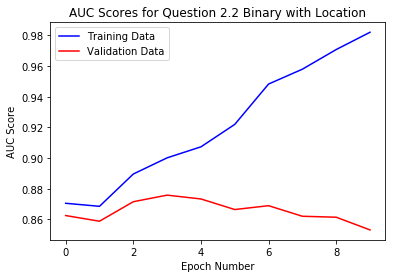

In [39]:
# This class replaces layer four in the ResNet model
# A convolution that reduces channel only
class LayerFourReplacement(torch.nn.Module):
    def __init__(self):
        super(LayerFourReplacement, self).__init__()
        self.convolution_layer_1 = torch.nn.Conv2d(in_channels = 256, out_channels = 1, kernel_size=1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.convolution_layer_1(x)
        x = self.sigmoid(x)
        return x
        
        
# Defint batch size
b_size = 15
# Get data loaders
train_loader = torch.utils.data.DataLoader(train_dataset_ex2, shuffle = True, batch_size = b_size, num_workers = 8)
val_loader = torch.utils.data.DataLoader(val_dataset_ex2, batch_size = b_size, num_workers = 8)

# Get resnet model 
# Send model to GPU
resnet_model = models.resnet18(pretrained = True)
resnet_model.layer4 = LayerFourReplacement()
resnet_model.avgpool = torch.nn.Sequential()
resnet_model.fc = torch.nn.Sequential()
resnet_model = resnet_model.cuda()

# Define Loss and optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.0005)

# Training
val_scores = []
train_scores = []
number_of_epochs = 10
target_score = 0.865
best_score = 0
best_model = copy.deepcopy(resnet_model)
for epoch in range(number_of_epochs):
    print('Epoch: ' + str(epoch))
    
    # Toggle to training mode
    resnet_model.train()

    losses = []
    for images, targets, grids in train_loader:
        # Zero out optimizer
        optimizer.zero_grad()
        # Send data to GPU
        images = images.cuda()
        targets = targets.cuda()
        grids = grids.cuda()
        # Get model prediction
        out = resnet_model(images)
        # Calculate loss
        loss = criterion(out, grids.view(grids.size(0), -1))
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()
        # Track losss
        losses.append(loss.item())
    
    # Output mean loss for this epoch
    print('Loss: ' + str(np.mean(losses)))
    
    # Get training data accuracy
    train_score = get_score_model_pneumonia_binary_with_location_model(resnet_model, train_loader)
    mean_train_score = np.mean(train_score)
    print('Trainig Score: ' + str(mean_train_score))
    train_scores.append(mean_train_score)
    
    # Get validation data accuracy
    val_score = get_score_model_pneumonia_binary_with_location_model(resnet_model, val_loader)
    mean_val_score = np.mean(val_score)
    print('Validation Score: ' + str(mean_val_score))
    val_scores.append(mean_val_score)
    
    # Save Best Model
    if mean_val_score > target_score and mean_val_score > best_score:
        best_score = mean_val_score
        best_model = copy.deepcopy(resnet_model)
        print('New Best Model Saved!')
    
# Plot Training and Validation AUC Score vs Epoch Number
plt.plot(range(number_of_epochs), train_scores, 'b', range(number_of_epochs), val_scores, 'r')
plt.title('AUC Scores for Question 2.2 Binary with Location')
plt.legend(['Training Data', 'Validation Data'])
plt.xlabel('Epoch Number')
plt.ylabel('AUC Score')
plt.show()

### Analysis Question 2.2
The model that used the location to perform the binary prediction did a bit better. The best AUC score for validation was 0.875821718127802 vs 0.8655758239404892. I think this is due to the greater amount of information used in the loss function for the binary with location; 196 probabilities vs one.   

### AUC Score for Test Data

In [40]:
# Predictions on Test Dataset
test_loader = torch.utils.data.DataLoader(test_dataset_ex2, batch_size = 15, num_workers = 8)
auc_score_test = get_score_model_pneumonia_binary_with_location_model(best_model, test_loader)
print('Test AUC Score: ' + str(auc_score_test))



Test AUC Score: 0.8732816789808927
